# fNIRS to fMRI
In this notebook, we develop a pipeline for turning fMRI data into pseudo-fNIRS data, and we apply it to the NSD.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
resolution = '1pt0' # 1.0 (for retrieving data from NSD)

# specify subject data
subjectID  = '01' # 01 to 08 subjects
sessionID  = '21' # 21 to 30 sessions
runID      = '01' # 01 to 12 runs

# Import and installation

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# install libraries
!pip install numpy pmcx jdata bjdata matplotlib

In [5]:
## uncomment if FSL library not installed
# !sudo apt -qq install file
# !wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fslinstaller.py
# !python3 fslinstaller.py

from pathlib import Path
fslpath = Path(os.getcwd()).parents[1].as_posix()+'/fsl'
os.environ["FSLDIR"] = fslpath
os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, 'bin')
!. ${FSLDIR}/etc/fslconf/fsl.sh

# Segmentation

In [6]:
from segmentation import get_segmentation

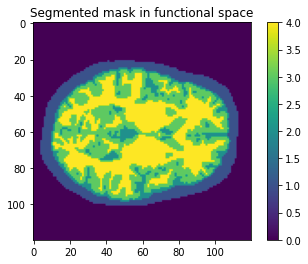

In [7]:
# retrieve mask of the subject's segmented head in fMRI space (~6min)
brainseg = get_segmentation(subjectID, resolution, sessionID, runID, plot=True)

# Forward solve

INPUT: 3D head mask is found in `data/subID/func/fmri/sessID/runID` 

OUTPUT: Measurement data in `data/subID/func/fnirs/sessID/runID`

In [13]:
import pmcx
pmcx.__version__   # print imported pmcx version number

'0.1.2'

In [14]:
pmcx.gpuinfo() # see gpu info

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42505273344,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

In [15]:
from optode_placement import get_optodes,save_optodes_json

In [16]:
srcpositions, detpositions, srcdirections = get_optodes(brainseg, nsources=10, ndetectors=100)
save_optodes_json(srcpositions,detpositions,srcdirections,brainseg,"test.json",json_boilerplate="colin27.json")

# Optode placement
To check where the optodes are placed, open [MCX Cloud](https://mcx.space/cloud).

1. Click JSON then replace the json with the contents of test.json.
2. Click update form, then Preview.

In [17]:
# generate a random volume of size 2 x Nx x Ny x Nz float32
# each element should be a random number between 0.5 and 1
vol = np.random.rand(2, 100, 100, 100).astype('float32') + 0.5

In [32]:
# TODO: properties might need revision
media_properties = [
    [0,       0,       1.0000,  1.0000], # background/air (not air pockets!)
    [0.0190,  7.8182,  0.8900,  1.3700], # scalp/skull
    [0.0040,  0.0090,  0.8900,  1.3700], # csf
    [0.0200,  9.0000,  0.8900,  1.3700], # gray matters
    [0.0800,  40.9000, 0.8400,  1.3700]] # white matters

# prop = [[0,0,1,1],[0,0,g,n]]

n = 1.37 # index of refraction
g = 0.9 # anisotropy factor

i = 0

cfg = {
       'nphoton': 1000000,
       'vol': brainseg,
       'tstart':0,
       'tend': 5e-9,
       'tstep': 1e-10,
       'srcpos': srcpositions[i],
       'srcdir': srcdirections[i],
       'detpos': detpositions,
       'prop': media_properties,
       'issavedet': True,
       }

In [33]:
res = pmcx.run(cfg)

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [51.0968, 107.979, 56.8623, 1]
srcdir: [-0, -0.937885, -0.346946, 0]
issavedet: 1


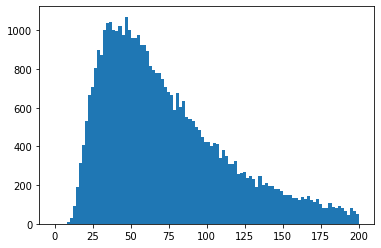

In [21]:
plt.hist(res['detp'][1], bins=100, range=[0,200])
plt.show()

In [1]:
import matplotlib.animation as animation

In [35]:
# Set up the figure
zidx = brainseg.shape[2] // 2
fig, ax = plt.subplots(figsize=(10, 10))

# Initial frame
im1 = ax.imshow(brainseg[:,:,zidx], animated=True, cmap='gray')
im2 = ax.imshow(np.log10(res['flux'][:,:,zidx, 0]), animated=True, alpha=0.5, cmap='jet')

# Update function
def update(t):
    im2.set_array(np.log10(res['flux'][:,:,zidx, t]))
    return im2,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=res['flux'].shape[3], blit=True)

# Save the animation
ani.save('visualization.mp4', writer='ffmpeg', fps=5)

plt.close(fig)

<ipython-input-35-c8aad1260d11>:7: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.imshow(np.log10(res['flux'][:,:,zidx, 0]), animated=True, alpha=0.5, cmap='jet')
<ipython-input-35-c8aad1260d11>:11: RuntimeWarning: divide by zero encountered in log10
  im2.set_array(np.log10(res['flux'][:,:,zidx, t]))
<ipython-input-35-c8aad1260d11>:11: RuntimeWarning: divide by zero encountered in log10
  im2.set_array(np.log10(res['flux'][:,:,zidx, t]))
